In [1]:
%load_ext tensorboard

import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

#Imports for functional API use
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import concatenate

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

In [2]:
# GPU options to limit OOM erors
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Clear old logs for tensorboard
!rm -rf ./logs/ 

In [3]:
# Load the processed CTs and measures lung volumes
ctdf = pd.read_pickle('ctdf.pkl')

In [4]:
# Load the preprocessed tabular features
features = pd.read_pickle('tabular_features.pkl')
len(features)

1535

In [5]:
# Drop any patients that we don't have CT data for
for row, i in features['Patient'].items():
    if i not in ctdf.index:
        features.drop(row, axis=0, inplace=True)

len(features)

1485

In [6]:
# Reshape for tensor input and then add the CT for each patient
ct_list = []
lungvol_list = []

for row, i in features['Patient'].items():
    ct = ctdf.loc[i, 'ct']
    reshaped = ct.reshape(20,200,200,1)
    ct_list.append(reshaped)
    lungvol_list.append(ctdf.loc[i, 'lung_vol'])
features['ct'] = ct_list


In [7]:
# Scale CT measured lung volumes and add to features dataframe

features['lung_vol'] = (np.array(lungvol_list) - np.array(lungvol_list).min()) / \
                      (np.array(lungvol_list).max() - np.array(lungvol_list).min())

In [8]:
features.columns

Index(['Patient', 'Sex_Female', 'Sex_Male', 'SmokingStatus_Currently smokes',
       'SmokingStatus_Ex-smoker', 'SmokingStatus_Never smoked', 'age', 'weeks',
       'base_fvc', 'fvc', 'ct', 'lung_vol'],
      dtype='object')

In [9]:
# Create train and test sets grouped by patient
# Maintain patient grouping to prevent leakage of test data into train set
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 9).split(features, groups=features['Patient']))

train = features.iloc[train_inds]
test = features.iloc[test_inds]
train.drop('Patient', axis=1, inplace=True)
test.drop('Patient', axis=1, inplace=True)

/home/swhebell/anaconda3/envs/osic-pf/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
# Split train and test into tabular and CT data
X_tab_train = train[['Sex_Female', 'Sex_Male', 'SmokingStatus_Currently smokes',
                     'SmokingStatus_Ex-smoker', 'SmokingStatus_Never smoked', 'age', 'weeks', 'base_fvc', 'lung_vol']]
X_ct_train = np.asarray(list(train['ct']))
y_train = train['fvc']
X_tab_test = test[['Sex_Female', 'Sex_Male', 'SmokingStatus_Currently smokes', 
                   'SmokingStatus_Ex-smoker', 'SmokingStatus_Never smoked', 'age', 'weeks', 'base_fvc', 'lung_vol']]
X_ct_test = np.asarray(list(test['ct']))
y_test = test['fvc']

In [13]:
# create constants for the loss function
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

# define competition metric
def score(y_true, y_pred):
    """Calculate the competition metric"""
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype = tf.float32) )
    metric = (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return tf.keras.backend.mean(metric)

# define pinball loss
def qloss(y_true, y_pred):
    """Calculate Pinball loss"""
    # Define quantiles (using quartiles currently)
    qs = [0.25, 0.50, 0.75]
    q = tf.constant(np.array([qs]), dtype = tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q * e, (q-1) * e)
    return tf.keras.backend.mean(v)

# combine competition metric and pinball loss to a joint loss function
def mloss(_lambda):
    """Combine Score and qloss"""
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda) * score(y_true, y_pred)
    return loss

In [14]:
# Create the MLP NN for the tabular branch

def create_mlp():
    
    model = models.Sequential()
    
    model.add(layers.Dense(128, activation='relu', input_shape=(9,), name='Tabular_Input'))
    model.add(layers.Dense(128, activation='relu'))
    
    return model

In [15]:
def create_cnn():
    
    model = models.Sequential()
    
    model.add(layers.Conv3D(32, (2, 5, 5), activation='relu', padding='same', data_format='channels_last',
                            input_shape=(20,200,200,1),
                            name='CT_input')) # set input shape to dimensions chosen for CT imaging
    model.add(layers.AveragePooling3D((1, 2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv3D(64, (2, 5, 5), activation='relu', padding='same'))
    model.add(layers.AveragePooling3D((1, 2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv3D(64, (2, 5, 5), activation='relu', padding='same'))
    model.add(layers.AveragePooling3D((1, 2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.SpatialDropout3D(0.3))
    
    model.add(layers.Flatten())
    
    
    model.add(layers.Dense(128, activation='relu'))
    
    return model

In [16]:
mlp = create_mlp()
cnn = create_cnn()

combinedInput = concatenate([mlp.output, cnn.output], name='Concatenate_MLP_CNN')
x = BatchNormalization()(combinedInput)
x = Dense(256, activation='relu', name='First_Combined_Layer', kernel_regularizer=tf.keras.regularizers.l1(0))(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0))(x)
#x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001))(x)
#x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0))(x)
#x = Dropout(0.3)(x)

# Output three quantiles as specified above in the qloss function
p1 = Dense(3, activation = "relu", name = "p1")(x)
# quantile adjusting p1 predictions
p2 = Dense(3, activation = "relu", name = "p2")(x)
preds = Lambda(lambda x: x[0] + tf.cumsum(x[1], axis = 1), name = "preds")([p1, p2])

model= Model(inputs=[mlp.input, cnn.input], outputs = preds, name='SpatialDropout3D_Simplified')

In [17]:
model.summary()

Model: "SpatialDropout3D_Simplified"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CT_input_input (InputLayer)     [(None, 20, 200, 200 0                                            
__________________________________________________________________________________________________
CT_input (Conv3D)               (None, 20, 200, 200, 1632        CT_input_input[0][0]             
__________________________________________________________________________________________________
average_pooling3d (AveragePooli (None, 20, 100, 100, 0           CT_input[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 100, 100, 128         average_pooling3d[0][0]          
________________________________________________________________________

In [18]:
# Compile the model - target mean_absolue_percentage_error
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
             loss= mloss(0.8),
             metrics=[score])

In [19]:
# Specify callbacks for tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Specify early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min',
                                                  restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(x=[X_tab_train, X_ct_train], y=y_train,
                    validation_data=([X_tab_test, X_ct_test], y_test),
                    batch_size = 4, epochs=10,
                    callbacks=[tensorboard_callback])

Epoch 1/10
296/296 [==============================] - 82s 277ms/step - loss: 420.0581 - score: 10.2540 - val_loss: 861.6468 - val_score: 20.3843
Epoch 2/10
284/296 [===========================>..] - ETA: 2s - loss: 158.7880 - score: 7.7852

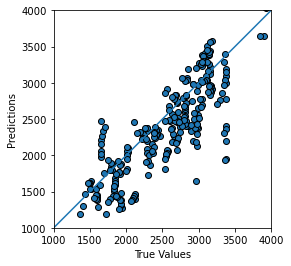

In [21]:
# Look for bias

predictions = model.predict([X_tab_test, X_ct_test], batch_size=1)
a = plt.axes(aspect='equal')
plt.scatter(predictions[:,1], y_test, edgecolors=(0, 0, 0))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [1000, 4000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
#### TO DO ###
# Parameter optimisation
# Optimise neural net complexity - in progress
# Implement group K-fold validation
# Forecast on test set for all weeks and plot results with quantiles for error